## Image Compression Using Singular Value Decomposition
Note that the use of an image as a data set in this demonstration is different than how we used images for demonstrating PCA. In the case of PCA, each image was an object and the pixel values (flattened) were the features. PCA allowed us to analyze the entire data set of images.

For SVD, we are assuming that each row in the image is a data object and the column values are the features.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sparsesvd import sparsesvd

from PIL import Image

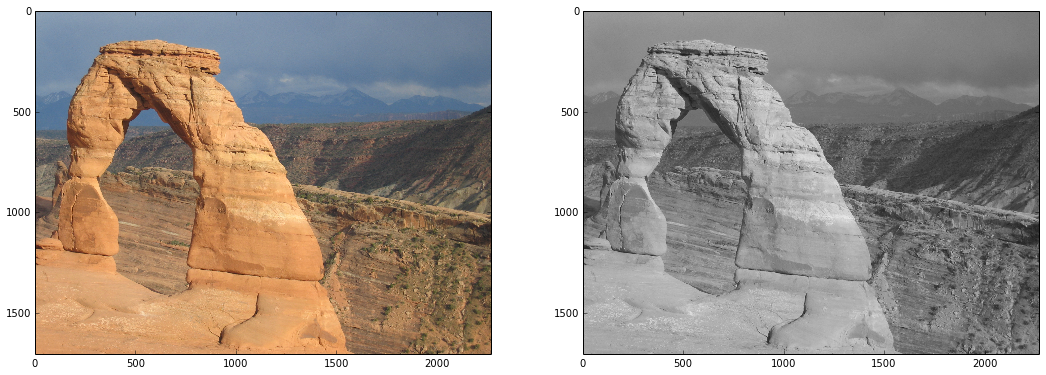

In [10]:
#load a random image and convert it into black and white
img = Image.open('../data/arch.jpg')
imggray = img.convert('LA')
fig = plt.figure(figsize=(18, 12))
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(imggray)

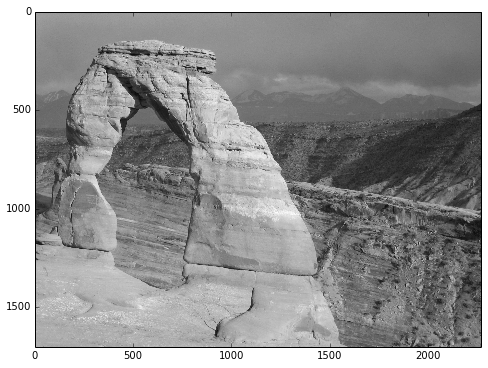

In [12]:
# convert image to a np matrix (the underlying data is unchanged)
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
X = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(X, cmap='gray');

In [13]:
# compute SVD for the matrix
U, S, V = np.linalg.svd(X)

Computing an approximation of the image using the first column of U and first row of V reproduces the most prominent feature of the image, the light area on top and the dark area on the bottom. The darkness of the arch causes the extra darkness in the middle of the reconstruction. 

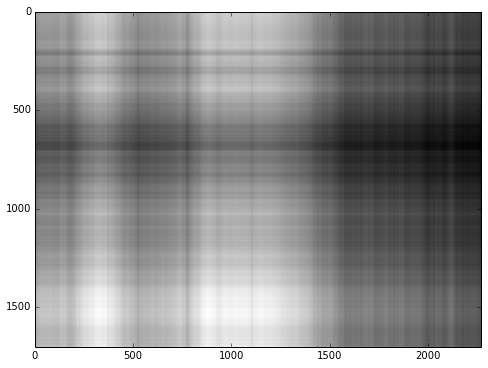

In [20]:
Z = np.matrix(U[:, :1]) * np.diag(S[:1]) * np.matrix(V[:1, :])
plt.figure(figsize=(9,6))
plt.imshow(Z, cmap='gray');

This is the best rank-1 approximation that you can get (for Frobenius norm).
Now compute the reconstruction for higher rank approximations.

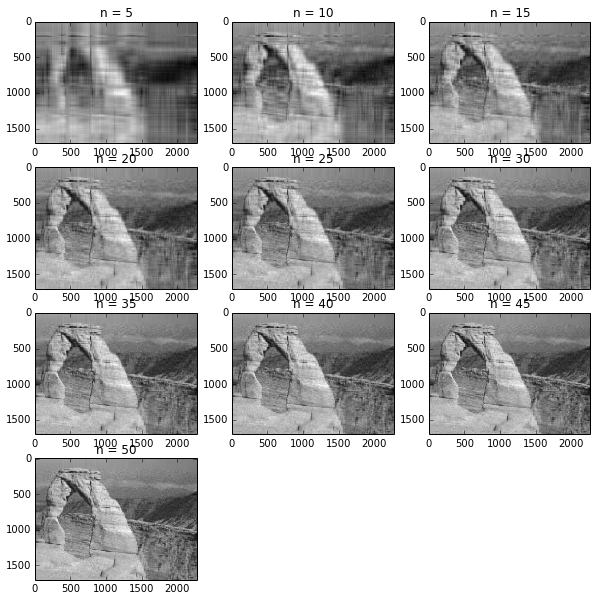

In [23]:
fig = plt.figure(1,figsize=[10,10],dpi=300)
c = 1
for i in xrange(5, 51, 5):
    Z = np.matrix(U[:, :i]) * np.diag(S[:i]) * np.matrix(V[:i, :])
    plt.subplot(4,3,c)
    c = c + 1
    plt.imshow(Z, cmap='gray')
    title = "n = %s" % i
    plt.title(title)

## Users and Items: Finding the Right Customer Using Matrix Completion using SVD
(Shamelessly) copied from http://www.thoughtfultech.co.uk/matrix-completion-for-users-and-items.html


So let us imagine you have got a website doing great trade in widgets, selling them to users that you have registered. Cleverly, you've kept track of what users buy, so you have a complete picture of the site's shopping status. Great!, but how useful is this data? You really want to target customers with products they might have a genuine interest in without it being classed as "spam". The system you require is usually called a __Recommender System__ and should be an integral part of the marketing process in your business. 

There are two key things you can do with this type of system:

1. Recommend products that you think users will like, to the right user.
2. Figure out what stock you need.

So what does this type of data look like? The best way to structure the data is to present the "users" as rows and "items" as columns. This naturally forms a matrix with the amounts bought as elements and with missing values as the values we mainly wish to predict. Missing values are potential selling points, so we can target users with these products either through direct mail or product placement when they view the website. It also gives some indication of the amount of stock that might be required for each item. So a little shop selling ten items to eight customers would be best represented by a matrix that looks like this: 
$$
X = \left(
\begin{array}{ccccccccccc}
                      & Chocolate & TV & Peanuts & Crisps & Wine & Beer & Champagne & Ginger Beer & Lemonade & Orange Juice  \\ 
                Jim & 1  & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & 2\\
                Brenda & 4  & \_ &  5 & 5 & 6 & 7 & 6 & \_ & 7 & 1\\
                Jonny & \_ & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & \_ \\
                Jo & 3  & \_ & \_ & 2 & 1 & 4 & 6 & 1 & 4  & \_\\  
                Rosa & 3  & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & \_\\  
                Ruby & \_ &  3 &  3 & 4 & 4 & 4 & 4 & 5  & 6 & 2\\ 
                Julie & 3  & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & \_\\
                Karen & 3  & 6  & \_ & \_ & \_ & \_ & \_ & \_ & 5 & 2 \\
                \end{array} 
\right)
$$

This we will call the "Source" matrix, Each row/column combination records how much of a product (column) has been bought by a user (row).
In addition, we might simplify this view to generate a binary "interaction" matrix. This is the above data simplified to record whether an item has been bought (1) or not (_). 

$$
X_b = \left( \begin{array}{ccccccccccc}
                       & Chocolate & TV & Peanuts & Crisps & Wine & Beer & Champagne & Ginger Beer & Lemonade & Orange Juice  \\ 
                Jim & 1  & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & 1\\
                Brenda & 1  & \_ &  1 & 1 & 1 & 1 & 1 & \_ & 1 & 1\\
                Jonny & \_ & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & \_ \\
                Jo & 1  & \_ & \_ & 1 & 1 & 1 & 1 & 1 & 1  & \_\\  
                Rosa & 1  & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & \_\\  
                Ruby & \_ &  1 &  1 & 1 & 1 & 1 & 1 & 1  & 1 & 1\\ 
                Julie & 1  & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & \_\\
                Karen & 1  & 1  & \_ & \_ & \_ & \_ & \_ & \_ & 1 & 1 \\
                \end{array} 
\right)
$$

In Numpy this would look something like this:

In [4]:
#generate the data for this chapter
X = np.array([[1,0,0,2,1,4,6,0,5,2],
             [4,0,5,2,1,4,6,0,5,1],
             [0,0,0,2,1,4,6,1,4,0],
             [3,0,0,2,1,4,6,0,5,0],
             [3,0,0,2,1,4,6,0,5,0],
             [0,3,3,4,4,4,4,5,6,2],
             [3,0,0,2,1,4,6,0,5,0],
             [3,6,0,0,0,0,0,0,5,2],])
Xb = X.clip(0,1) #clip ound everything above 1 to 1
print "X=\n" + str(X)
print "Xb=\n" + str(Xb)

X=
[[1 0 0 2 1 4 6 0 5 2]
 [4 0 5 2 1 4 6 0 5 1]
 [0 0 0 2 1 4 6 1 4 0]
 [3 0 0 2 1 4 6 0 5 0]
 [3 0 0 2 1 4 6 0 5 0]
 [0 3 3 4 4 4 4 5 6 2]
 [3 0 0 2 1 4 6 0 5 0]
 [3 6 0 0 0 0 0 0 5 2]]
Xb=
[[1 0 0 1 1 1 1 0 1 1]
 [1 0 1 1 1 1 1 0 1 1]
 [0 0 0 1 1 1 1 1 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [0 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 0 1 0]
 [1 1 0 0 0 0 0 0 1 1]]


We replace the blanks with zeros, knowing these are the values we need to estimate. Once we have estimated the blanks we can build a recommendation. Looking at the above matrix a sensible recommendation might be Chocolate for Ruby and Ginger Beer for Rosa, when the user next logged onto the website this would be shown in the now common "we recommend" element usually towards the bottom of the page. For Ruby the first item would be Chocolate and for Rosa this would be Ginger Beer.
 
 
##Recommender Algorithms
 
  The big question is how might we do this? The most obvious approach is to use what we know about similar user's purchasing patterns to predict user's unknown values. Likewise, we can also use what we know about how similar products have sold to predict a product's unknown values. These approaches are known as __Collaborative Filtering__. A second less obvious method from the field of statistics is to try and predict the underlying drivers for the _user buys item_ decision process using a __Latent Factor Model__ in our case using __Singular Valued Decomposition__. 

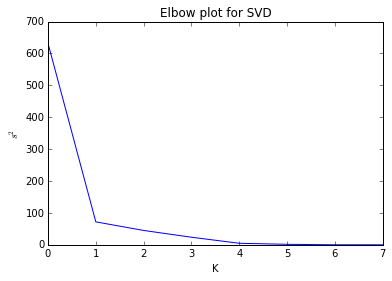

X=
[[1 0 0 2 1 4 6 0 5 2]
 [4 0 5 2 1 4 6 0 5 1]
 [0 0 0 2 1 4 6 1 4 0]
 [3 0 0 2 1 4 6 0 5 0]
 [3 0 0 2 1 4 6 0 5 0]
 [0 3 3 4 4 4 4 5 6 2]
 [3 0 0 2 1 4 6 0 5 0]
 [3 6 0 0 0 0 0 0 5 2]]
U=
[[-0.4  0.1 -0.   0.3  0.8 -0.4  0.  -0. ]
 [-0.4  0.1 -0.1 -0.9  0.2  0.2 -0.   0. ]]
V=
[[-0.2 -0.1]
 [-0.  -0.7]
 [-0.6 -0.2]
 [-0.4  0.2]
 [-0.5 -0. ]
 [-0.4  0.4]
 [ 0.3 -0. ]
 [-0.1  0.1]
 [-0.1 -0.3]
 [ 0.1  0.3]]
X'=
[[ 2.  0.  1.  2.  1.  4.  6.  1.  5.  1.]
 [ 2.  1.  1.  2.  1.  4.  6.  1.  6.  1.]
 [ 2. -0.  1.  2.  1.  4.  5.  0.  4.  0.]
 [ 2. -0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2. -0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2.  4.  2.  3.  2.  3.  4.  2.  7.  2.]
 [ 2. -0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 1.  5.  2.  1.  2.  1. -0.  2.  4.  2.]]


In [5]:
from scipy.linalg import svd,diagsvd
#simple calculate of the necessary SVD matrices
U, s, Vh = svd(X)
#plot the elbow plot
plt.plot(s**2)
plt.xlabel("K")
plt.ylabel('$s^2$')
plt.title('Elbow plot for SVD')
plt.show()
#truncate to 2 
s[2:]=0
#calculate estimate using truncated S
outX = np.round(np.dot(np.dot(U,diagsvd(s,8,10)),Vh))
#show results
print "X=\n"+str(X)
print "U=\n"+str(U[:2,:].round(1))
print "V=\n"+str(Vh[:,:2].round(1))
print "X'=\n"+str(outX)

The new non-zero values maybe used to recommend new products to customers. For instance, one could predict several new items to Karen (last row)!!